In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# Basic Features

In [2]:
def get_basic_features(path):
    features, feature_names = [], []
    for stat in ["BVP", "HR", "EDA", "TEMP"]:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        features += [signal.min(), signal.max(), signal.mean(), signal.std()]
        feature_names += [f"{stat}_{f}" for f in ["min", "max", "mean", "std"]]
    return feature_names, features

In [3]:
metadata = pd.read_csv("metadata.csv")
basic_ds = []
for path in metadata['Path']:
    feature_names, features = get_basic_features(path)
    basic_ds.append(features)
    
basic_ds = pd.DataFrame(basic_ds, columns = feature_names)

In [4]:
X = basic_ds.values[:, 3:] #can only be poitive, and BVP can be negative too

In [5]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [6]:
X.shape

(312, 13)

In [7]:
H.shape

(2, 13)

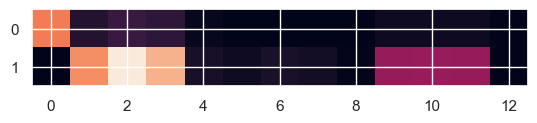

In [8]:
plt.imshow(H, interpolation='nearest')
plt.show()

In [55]:
(W@H).shape

(312, 13)

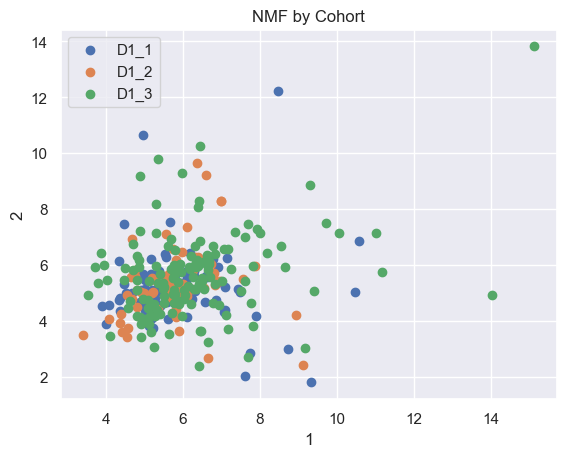

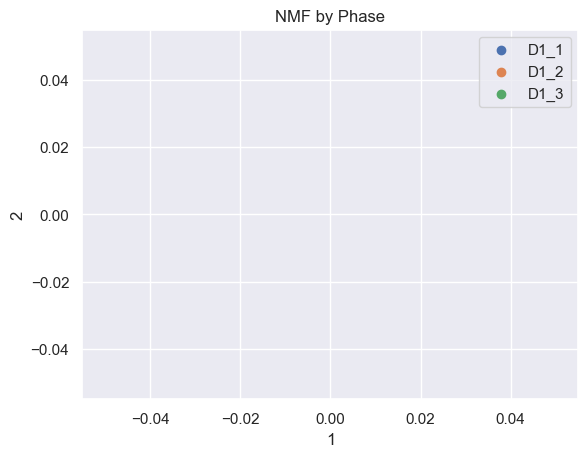

In [18]:
def visualize(meta, W, by_column):
    plt.figure()
    for c in ["D1_1", "D1_2", "D1_3"]:
        idxs = meta[by_column].str.startswith(c)
        plt.scatter(W[idxs, 0], W[idxs, 1], label=c)
    #plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label='orig')
    plt.title(f"NMF by {by_column}")
    plt.xlabel("1")
    plt.ylabel("2")
    plt.legend()
    plt.show()
    
visualize(metadata, W, "Cohort")
visualize(metadata, W, "Phase")


# Based on Raw data

Min 0 days 00:03:43.250000, Min 0 days 00:03:43.437500, Min 0 days 00:03:43, Min 0 days 00:03:43.250000, 

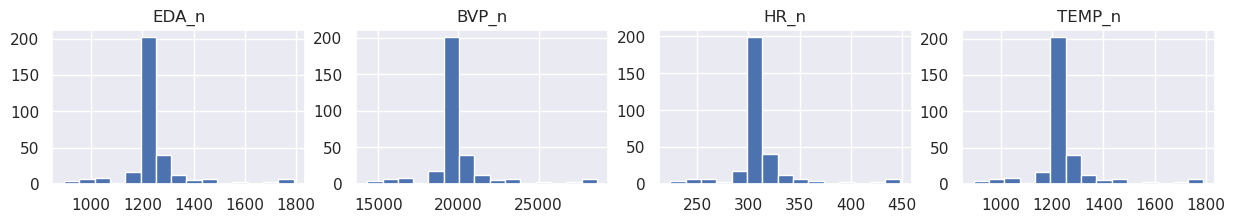

In [91]:
fig, axs = plt.subplots(ncols=4)
fig.set_figheight(2)
fig.set_figwidth(15)
stat_n = ['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']
min_n = {stat: 0 for stat in stat_n}
for i, colname in enumerate(stat_n):
    min_n[colname] = metadata[colname].min()
    print("Min", metadata[colname[:-1]+'duration'].min(), end=', ')
    axs[i].hist(metadata[colname], bins=15)
    axs[i].set_title(colname)
plt.show()

In [92]:
min_n

{'EDA_n': 894, 'BVP_n': 14301, 'HR_n': 224, 'TEMP_n': 894}

## Option 1 - use lowest

In [11]:
def get_standardized_signals(stat, n=None, last = True):
    if not n:
        n = metadata[['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']].min()[stat+'_n']

    raw_ds = []
    for path in metadata['Path']:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        if last:
            signal = signal.values[-n:]
        else:
            signal = signal.values[:n]
        raw_ds.append(signal)
    
    raw_ds = pd.DataFrame(raw_ds, index=metadata['Path'])
    return raw_ds

raw_ds = get_standardized_signals("HR")

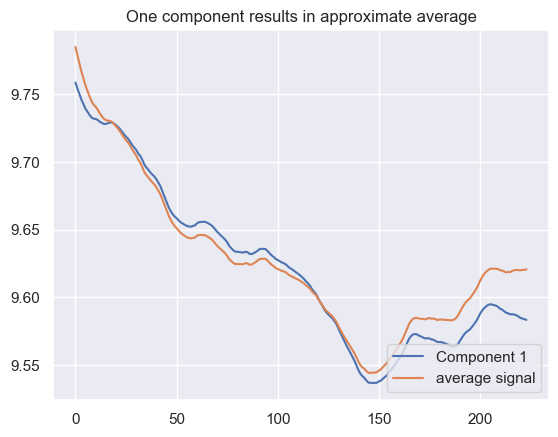

In [12]:
X = raw_ds.values

model = NMF(n_components=1, init='nndsvda', solver='mu')
W = model.fit_transform(X)
H = model.components_

plt.figure()
plt.title("One component results in approximate average")
plt.plot(H[0, :], label=f"Component 1")
plt.plot(X.mean(axis=0)/8.05, label='average signal')
plt.legend(loc='lower right')
plt.show()

Iter 10


<Figure size 1000x1000 with 0 Axes>

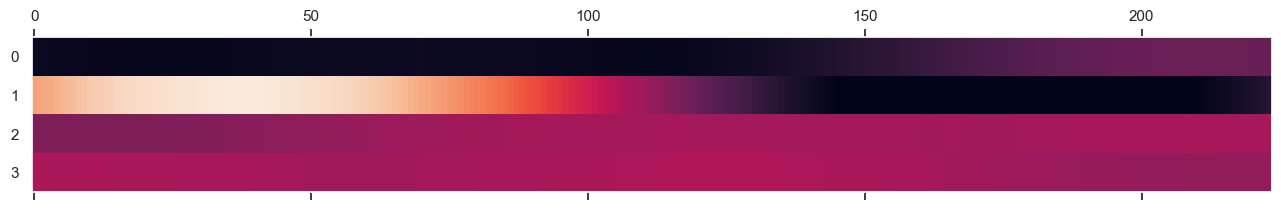

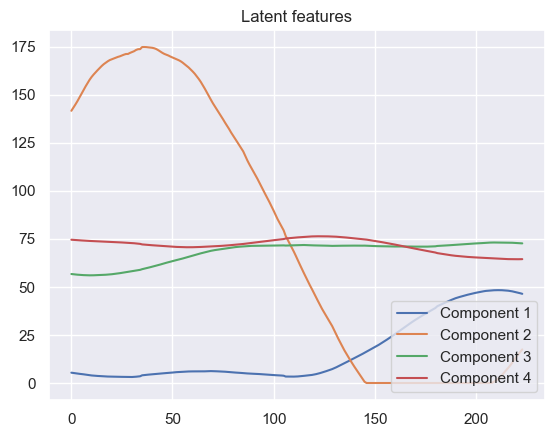

In [25]:
# how many components results in the highest expalined variance while not overfitting?
# by default it doesn't regularize W and H, maybe we should impose some for stability?
X = raw_ds.values
model = NMF(n_components=4, init='nndsvda', solver='cd')
W = model.fit_transform(X)
H = model.components_
print("Iter", model.n_iter_)

plt.figure(figsize=(10, 10))
plt.matshow(H,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features")
for i in range(H.shape[0]):
    plt.plot(H[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

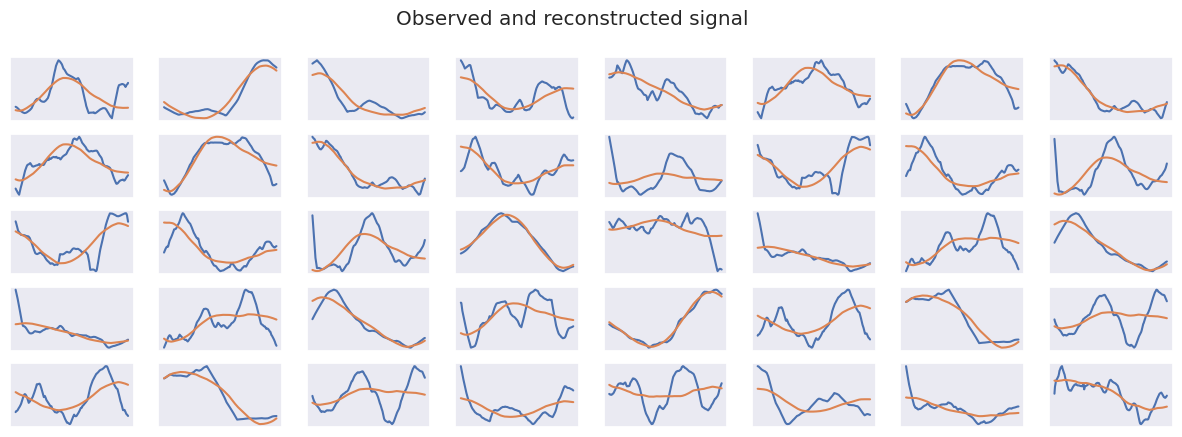

In [599]:
nrows = 5
ncols = 8
fig, axs = plt.subplots(ncols = ncols, nrows=nrows)
fig.set_figwidth(15)
for i in range(nrows):
    for j in range(ncols):
        idx = i*ncol+j
        observed = pd.read_csv(f"{metadata['Path'][idx]}/HR.csv")["HR"].values[-224:]
        #reconstructed = (W@H)[idx, :]
        reconstructed = (W[idx, :]@H)
        axs[i, j].plot(observed)
        axs[i, j].plot(reconstructed)
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        
fig.suptitle("Observed and reconstructed signal")
plt.show()

In [590]:
# to interpret results: 
# 1. describe features with words e.g high, decreasing heart rate
# 2. Is there a difference in how much of each feature contribute to the reconstuction for each phase?

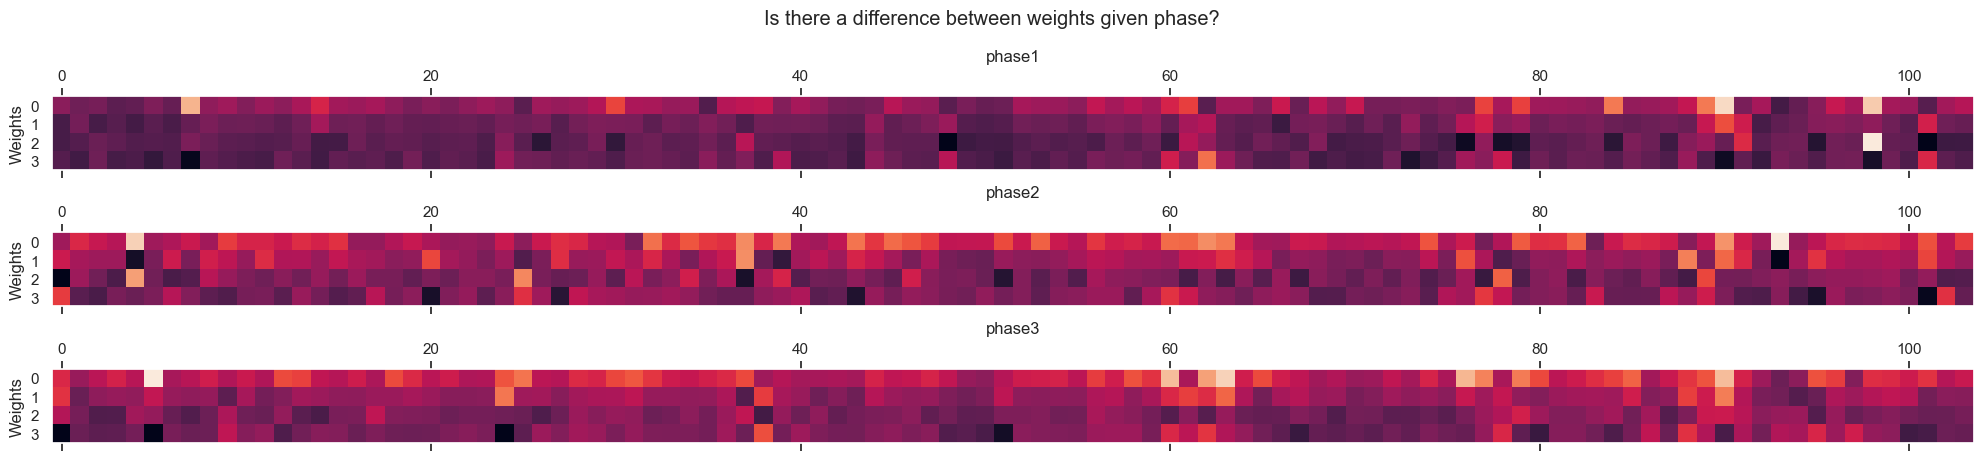

In [22]:
fig, axs = plt.subplots(nrows=3)
fig.set_figwidth(20)
fig.suptitle("Is there a difference between weights given phase?")
for i, phase in enumerate(metadata['Phase'].unique()):
    idxs = metadata['Phase'] == phase
    axs[i].set_title(phase)
    axs[i].matshow(W[idxs, :].T)
    axs[i].grid(False)
    axs[i].set_ylabel("Weights")
    #axs[i].set_xlabel("Observations")
plt.tight_layout()
plt.show()

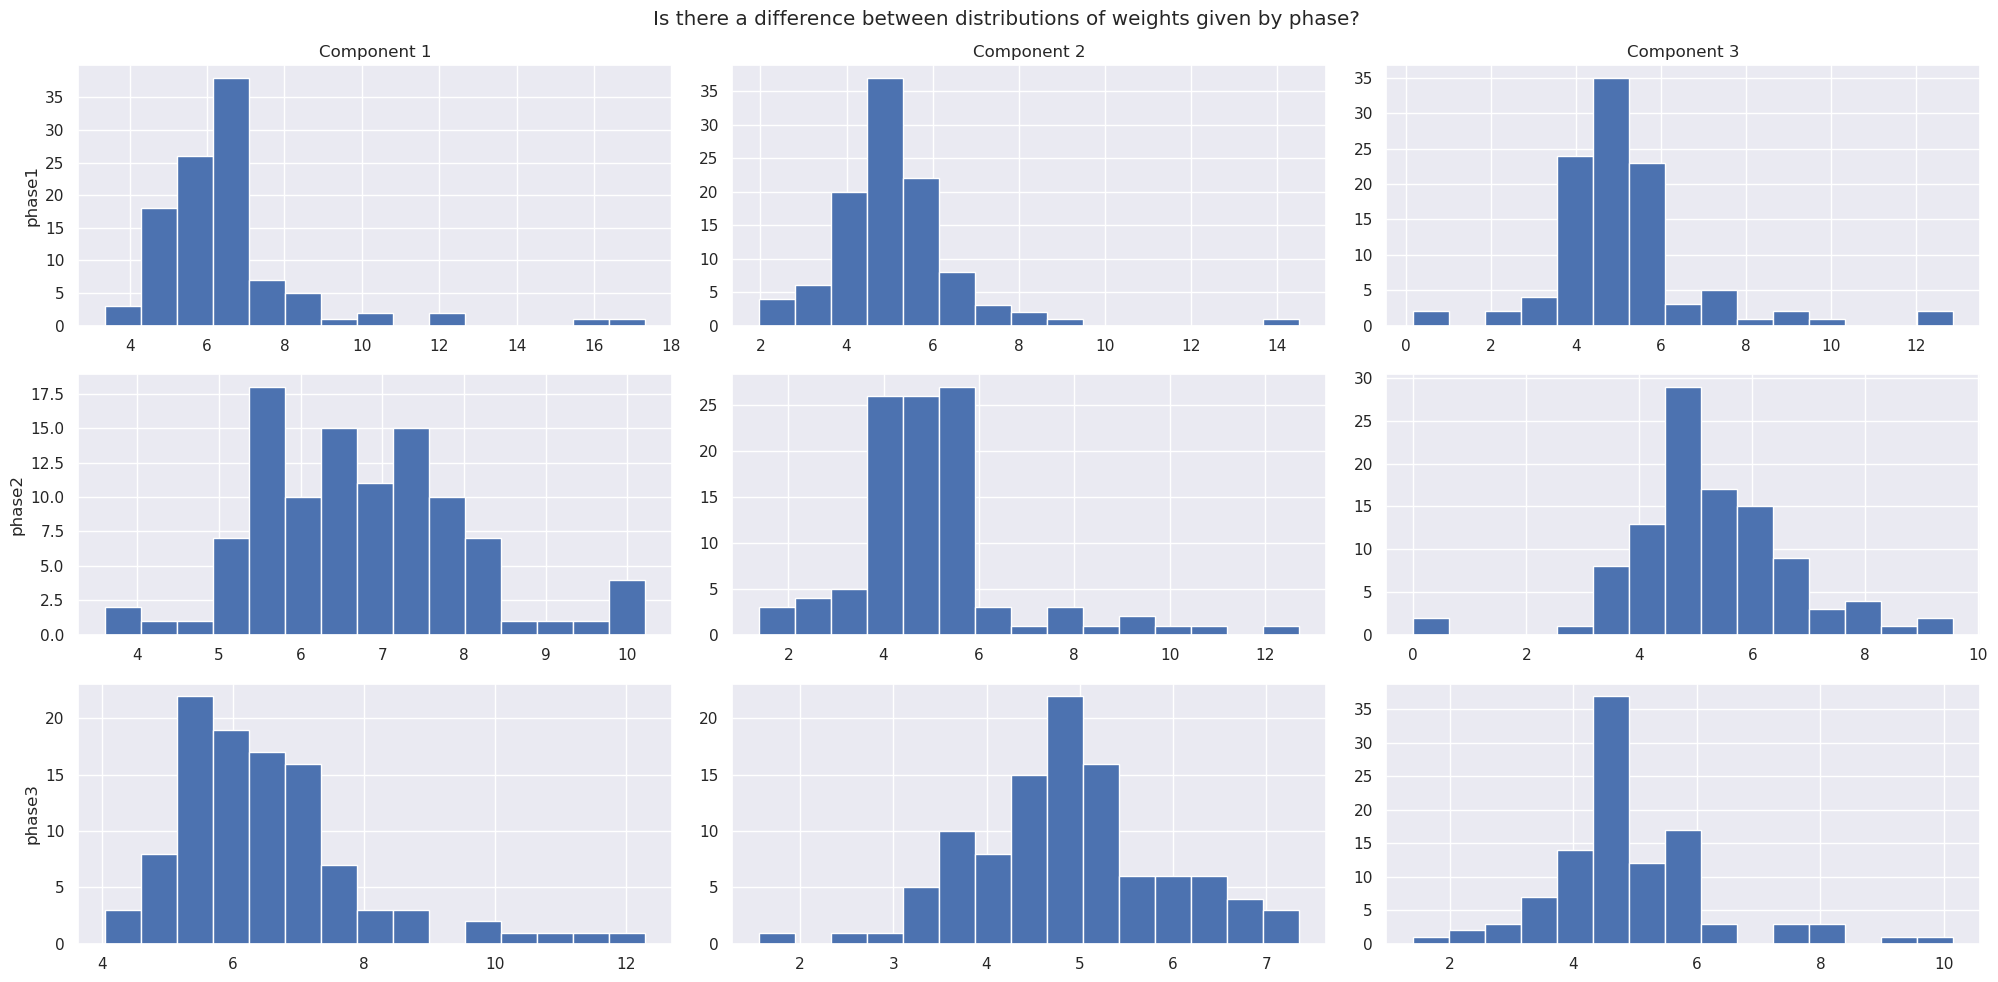

In [601]:
n_comp = W.shape[1]
fig, axs = plt.subplots(nrows=3, ncols=n_comp)
fig.suptitle("Is there a difference between distributions of weights given by phase?")
fig.set_figwidth(20)
fig.set_figheight(10)
for i, phase in enumerate(metadata['Phase'].unique()):
    idxs = metadata['Phase'] == phase
    for j in range(n_comp):

        axs[i, j].hist(W[idxs, j].T, bins=15)
        if i == 0:
            axs[i, j].set_title(f"Component {j+1}")
        if j == 0:
            axs[i, j].set_ylabel(phase)
        
plt.tight_layout()
plt.show()

In [603]:
metadata.columns

Index(['Path', 'Cohort', 'Trial', 'Round', 'Phase', 'Role', 'participant_ID',
       'parent/puzzler', 'team_ID', 'E4_nr', 'upset', 'hostile', 'alert',
       'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid',
       'active', 'frustrated', 'difficulty', 'BVP_duration', 'BVP_n',
       'HR_duration', 'HR_n', 'EDA_duration', 'EDA_n', 'TEMP_duration',
       'TEMP_n'],
      dtype='object')

In [ ]:
# get mse